Imports

In [2]:
import os
import math
import cv2
import random
import numpy as np
import tensorflow as tf
import datetime as dt
import matplotlib.pyplot as mp

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seedcons = 27
np.random.seed(seedcons)
random.seed(seedcons)
tf.random.set_seed(seedcons)

Taking the dataset

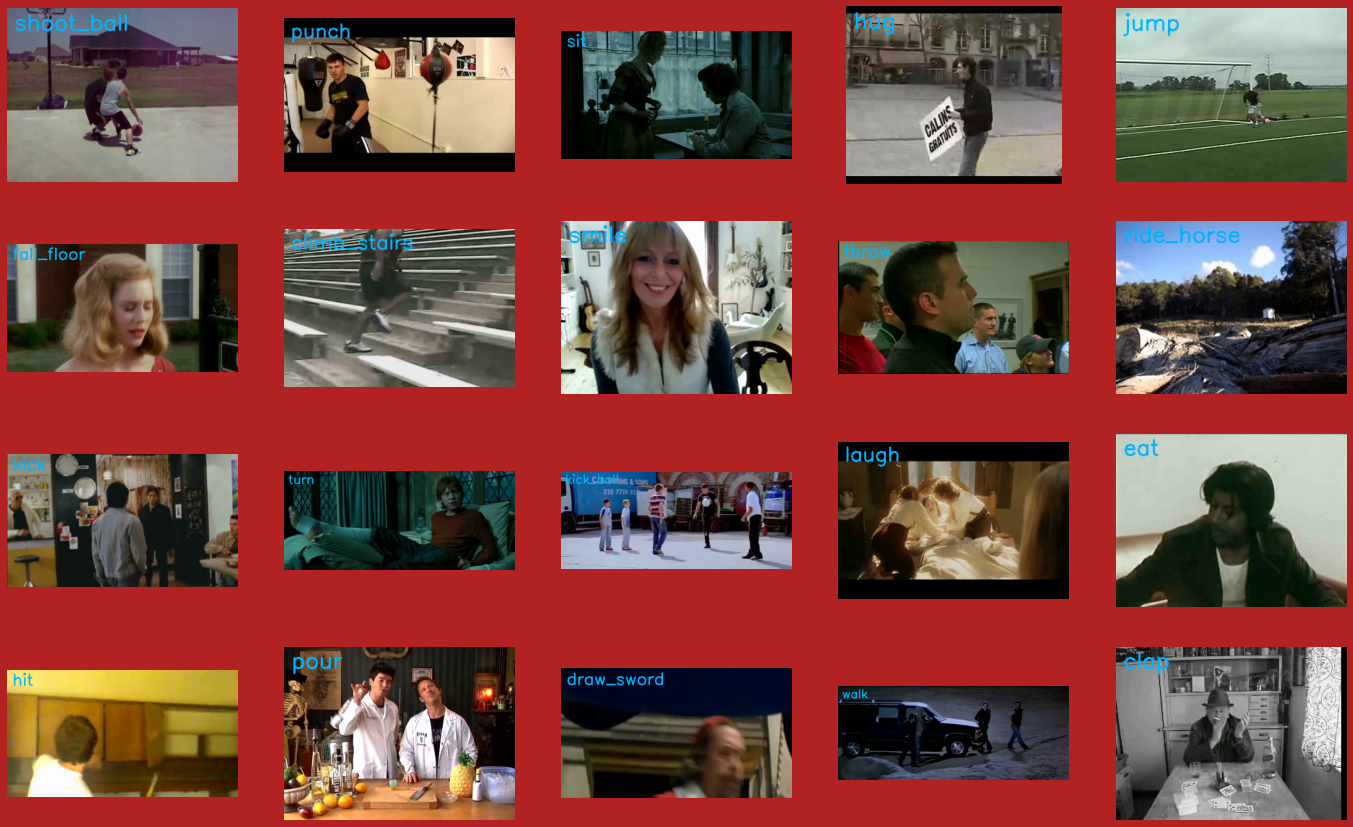

In [4]:
#Setting up the figure size
fig = mp.figure(figsize=(24,15))
# mp.figure(figsize = (24,15))
fig.patch.set_facecolor('firebrick')
fig.set_alpha(1.0)

#searching for Folder 'ActionDataset'
class_name = os.listdir('ActionDataset')

# print(class_name)

#Picking up the random 20 class from the dataset
randsam = random.sample(range(len(class_name)),20)

# print(randsam)
#forloop for taking each class and select one video from each class
for counter, random_index in enumerate(randsam,1):
    #selecting the class name
    selclass = class_name[random_index]

    #Path going to the directory from the dataset folder
    vidlist = os.listdir(f'ActionDataset/{selclass}')

    #Selecting one video from the class selected above
    selvid = random.choice(vidlist)

    #Reading the video from the path "Dataset->Selected Class->Selected Video of the selected class"
    vidred = cv2.VideoCapture(f'ActionDataset/{selclass}/{selvid}')

    #storing the status and no of frames in that particular video
    suc, fra = vidred.read()

    #Releasing the video from the read
    vidred.release()

    #Converting the BGR color space to RGB color space
    #There are more that 150 color space in opencv
    rgb_frame = cv2.cvtColor(fra, cv2.COLOR_BGR2RGB)



    #Put text is used to draw any text on the video
    #(image on which text should come,text that should be drawn, XY coordinate to place the text, font of the text,multiplication of the fontbase size, color of the text, tickness of the text)
    #Here it puts the name of the class that is selected
    cv2.putText(rgb_frame, selclass,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,180,255),2)
    mp.subplot(4,5,counter);mp.imshow(rgb_frame);mp.axis('off')

Data Preprocessing

In [5]:
ih,iw = 64,64

fralen = 20

dir = 'ActionDataset'

class_list = ['walk', 'smile', 'laugh', 'hit', 'drink', 'sit', 'turn', 'stand', 'eat', 'talk', 'throw']

In [6]:
def frame(path):
    
    fralis = []

    vidred = cv2.VideoCapture(path)

    vidfracount = int(vidred.get(cv2.CAP_PROP_FRAME_COUNT))

    skipfra = max(int(vidfracount/fralen),1)

    for i in range(fralen):
        vidred.set(cv2.CAP_PROP_FRAME_COUNT,i*skipfra)

        succ, fram = vidred.read()

        if not succ:
            break

        #resizing the frame by 64x64
        resfra = cv2.resize(fram,(ih,iw))

        #normalized frama
        norfra = resfra/255

        fralis.append(norfra)

    vidred.release()

    return fralis

Data set creation

In [7]:
def credata():

    features = []
    lables = []
    vidpath = []

    for clin, clna in enumerate(class_list):
        print(f'Extracting data of the class : {clna}')
        filis = os.listdir(os.path.join(dir,clna))

        for fina in filis:
            vidfilpath = os.path.join(dir,clna,fina)
            frames = frame(vidfilpath)
            if len(frames) == fralen:
                features.append(frames)
                lables.append(clin)
                vidpath.append(vidfilpath)

    features = np.asarray(features)
    lables = np.array(lables)

    return features, lables, vidpath

features, lables, vidpath = credata()

#one hot encoded vector
oneenvec = to_categorical(lables)

Extracting data of the class : walk
Extracting data of the class : smile
Extracting data of the class : laugh
Extracting data of the class : hit
Extracting data of the class : drink
Extracting data of the class : sit
Extracting data of the class : turn
Extracting data of the class : stand
Extracting data of the class : eat
Extracting data of the class : talk
Extracting data of the class : throw


In [8]:
ftrain, ftest, ltrain, ltest = train_test_split(features, oneenvec, test_size= 0.20, shuffle= True, random_state=seedcons)

Model Building

In [9]:
def consmod():
    model = Sequential()

    model.add(ConvLSTM2D(filters= 4, kernel_size = (3,3), activation = 'tanh', data_format="channels_last", recurrent_dropout = 0.2, return_sequences = True, input_shape = (fralen, ih, iw, 3)))
    model.add(MaxPool3D(pool_size=(1,2,2), padding= 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters= 8, kernel_size = (3,3), activation = 'tanh', data_format="channels_last", recurrent_dropout = 0.2, return_sequences = True, input_shape = (fralen, ih, iw, 3)))
    model.add(MaxPool3D(pool_size=(1,2,2), padding= 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters= 12, kernel_size = (3,3), activation = 'tanh', data_format="channels_last", recurrent_dropout = 0.2, return_sequences = True, input_shape = (fralen, ih, iw, 3)))
    model.add(MaxPool3D(pool_size=(1,2,2), padding= 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters= 16, kernel_size = (3,3), activation = 'tanh', data_format="channels_last", recurrent_dropout = 0.2, return_sequences = True, input_shape = (fralen, ih, iw, 3)))
    model.add(MaxPool3D(pool_size=(1,2,2), padding= 'same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())
    model.add(Dense(len(class_list),activation = 'Softmax'))

    model.summary()

    return model

In [10]:
convmod = consmod()

print("Model created successfully!!!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

compile and training

In [16]:
earstop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convmod.compile(loss = 'categorical_crossentrophy', optimizer = 'Adam', metrics = ['accuracy'])

convmodtrainhis = convmod.fit(x=ftrain, y=ltrain, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = earstop)

MemoryError: Unable to allocate 1.13 GiB for an array with shape (1238, 20, 64, 64, 3) and data type float32

In [ ]:
modevahis = convmod.evaluate(ftest, ltest)

In [ ]:
modevaloss, modevaacc = modevahis

datetime = '%Y_%n_%d___%H_%M_%S'

currentdtdt = dt.datetime.now()

currentdtst = dt.datetime.strftime(currentdtdt, datetime)

modelfilename = f'Srihari_model___Date_Time_{currentdtst}___Loss_{modevaloss}___Accuracy_{modevaacc}.h5'

convmod.save(modelfilename)